In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import ipaddress
import multiprocessing
import pickle  # use to dump model
import re
import time
from datetime import datetime
from urllib.parse import urlencode, urlparse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from six.moves import urllib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

import keras
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

import xgboost as xgb
from xgboost import XGBClassifier

print(tf.__version__)

2.5.0


In [2]:
csv0 = pd.read_csv(
    "E:/Codes/Python/ML Phising Detector/Datasets/phishing_site_urls.csv"
)
csv0.columns = ["URL", "Label"]
csv1 = pd.read_csv("E:/Codes/Python/ML Phising Detector/Datasets/urldata.csv")
csv1.columns = ["URL", "Label"]
csv2 = pd.read_csv("E:/Codes/Python/ML Phising Detector/Datasets/urls.csv")
csv2.columns = ["URL", "Label"]
csv3 = pd.read_csv("E:/Codes/Python/ML Phising Detector/Datasets/domains.csv")
csv3.columns = ["URL", "Label"]
csv4 = pd.read_csv("E:/Codes/Python/ML Phising Detector/Datasets/alexa-domains.csv")
csv4.columns = ["URL", "Label"]
csv5 = pd.read_csv("E:/Codes/Python/ML Phising Detector/Datasets/majestic-domains.csv")
csv5.columns = ["URL", "Label"]
csv6 = pd.read_csv("E:/Codes/Python/ML Phising Detector/Datasets/malicious0.csv")
csv6.columns = ["URL", "Label"]
csv7 = pd.read_csv("E:/Codes/Python/ML Phising Detector/Datasets/malicious1.csv")
csv7.columns = ["URL", "Label"]
csv8 = pd.read_csv("E:/Codes/Python/ML Phising Detector/Datasets/combined0.csv")
csv8.columns = ["URL", "Label"]
dfeval = pd.read_csv("E:/Codes/Python/ML Phising Detector/Datasets/test.csv")

In [3]:
frames = [csv0, csv1, csv2, csv3, csv4, csv6, csv7, csv8]
cFrames = pd.concat(frames)
cFrames.to_csv("E:/Codes/Python/ML Phising Detector/Datasets/compiled.csv", index=False)
cFrames.shape[0]

4919235

In [5]:
cFrames = cFrames.drop_duplicates(subset=["URL"])
print(cFrames.shape[0])
cFrames.to_csv(
    "E:/Codes/Python/ML Phising Detector/Datasets/final_urls_partial.csv", index=False
)

3161422


In [6]:
dftrain = pd.read_csv('E:/Codes/Python/ML Phising Detector/Datasets/final_urls_partial.csv', dtype={'URL': str, 'Label': int})
dftrain.columns = ["URL", "Label"]

In [7]:
print(dftrain.head(10))

                                                 URL  Label
0                 en.wikipedia.org/wiki/Maiko_Watson      0
1  tvosxdfmkciqxvpwvbbnnrjifawkhznzifyx.offgl8876...      1
2                                  lloydsalert.co.uk      1
3                  onlinehuntintonbank.accesscam.org      1
4                              rbbn-cz-secure.online      1
5  heilpraktikerin-edhofer.de/wp-includes/pomo/ne...      1
6  attloginnewupdatingservicemailcommunication.we...      1
7                                     incomeways.icu      1
8  gallery.skcentral.com/displayimage.php?album=3...      0
9  rebelreign.com/2011/07/face-music-rebels-need-...      0


In [8]:
label_counts = pd.DataFrame(dftrain.Label.value_counts())
print(label_counts)
dftrain.shape[0]

     Label
0  2183801
1   977621


3161422

c:\users\steven\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Label'>

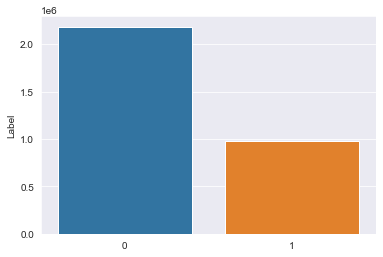

In [9]:
sns.set_style("darkgrid")
sns.barplot(label_counts.index, label_counts.Label)

In [10]:
def havingIP(url):
    try:
        ipaddress.ip_address(url)
        ip = 1
    except:
        ip = 0
    return ip


def haveAtSign(url):
    if "@" in url:
        at = 1
    else:
        at = 0
    return at


def getLength(url):
    if len(url) < 54:
        length = 0
    else:
        length = 1
    return length


def getDepth(url):
    s = urlparse(url).path.split("/")
    depth = 0
    for j in range(len(s)):
        if len(s[j]) != 0:
            depth = depth + 1
    return depth


def redirection(url):
    pos = url.rfind("//")
    if pos > 6:
        if pos > 7:
            return 1
        else:
            return 0
    else:
        return 0


def prefixSuffix(url):
    if "-" in urlparse(url).netloc:
        return 1
    else:
        return 0


shortening_services = (
    r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|"
    r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|"
    r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|"
    r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|"
    r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|"
    r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|"
    r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|"
    r"tr\.im|link\.zip\.net"
)


def tinyURL(url):
    match = re.search(shortening_services, url)
    if match:
        return 1
    else:
        return 0

In [11]:
def featureExtraction(url):

    features = []
    features.append(havingIP(url))
    features.append(haveAtSign(url))
    features.append(getLength(url))
    features.append(getDepth(url))
    features.append(redirection(url))
    features.append(tinyURL(url))
    features.append(prefixSuffix(url))

    return features

In [12]:
start_time = datetime.now()

dArr = []
for index, row in dftrain.iterrows():
    print(index, end="\r")
    url = dftrain.URL[index]
    dArr.append(featureExtraction(url))

end_time = datetime.now()
print("Duration: {}".format(end_time - start_time))

Duration: 0:06:17.952185


In [13]:
feature_names = [
    "Have_IP",
    "Have_At",
    "URL_Length",
    "URL_Depth",
    "Redirection",
    'TinyURL',
    "Prefix/Suffix",
]

dArr = pd.DataFrame(dArr, columns=feature_names)
dftrain = pd.concat([dftrain, dArr], axis=1, join="inner")
dftrain.sample(20)

,URL,Label,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,TinyURL,Prefix/Suffix
567925,envoyserials.cf,1,0,0,0,1,0,0,0
1949824,internetwars.ru,0,0,0,0,1,0,0,0
3070129,showdepremios.org/ML/jms/mlb/lgz/,1,0,0,0,5,0,0,0
1555987,ead.adm.ufg.br,0,0,0,0,1,0,0,0
2214820,nos.org.uk,0,0,0,0,1,0,0,0
2951942,ytumg-stratumlab.inc.v3.antpool.com,1,0,0,0,1,0,0,0
1801628,qwpda.com,0,0,0,0,1,0,0,0
2922588,uf7.openvpn.openvpn.f2pool.com,1,0,0,0,1,0,0,0
1333926,patcdn.net,0,0,0,0,1,0,0,0
155312,videolala.com/watch-broncho-billy-and-the-indi...,0,0,0,1,2,0,0,0


In [14]:
def treat_data(datain):
    tokenizer = RegexpTokenizer(r"[A-Za-z]+")
    tokenizer.tokenize(datain.URL[0])
    print("Getting words tokenized ...")
    t0 = time.perf_counter()
    datain["text_tokenized"] = datain.URL.map(lambda t: tokenizer.tokenize(t))
    t1 = time.perf_counter() - t0
    print("Time taken", t1, "sec")

    stemmer = SnowballStemmer("english")
    print("Getting words stemmed ...")
    t0 = time.perf_counter()
    datain["text_stemmed"] = datain["text_tokenized"].map(
        lambda l: [stemmer.stem(word) for word in l]
    )
    t1 = time.perf_counter() - t0
    print("Time taken", t1, "sec")

    print("Getting joiningwords ...")
    t0 = time.perf_counter()
    datain["text_sent"] = datain["text_stemmed"].map(lambda l: " ".join(l))
    t1 = time.perf_counter() - t0
    print("Time taken", t1, "sec")

    dataout = datain
    return dataout

In [15]:
dftrain = treat_data(dftrain)
dftrain.shape

Getting words tokenized ...
Time taken 6.714006499999982 sec
Getting words stemmed ...
Time taken 104.54755050000006 sec
Getting joiningwords ...
Time taken 0.7493552999999338 sec


(3161422, 12)

In [16]:
dftrain.sample(10)

,URL,Label,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,TinyURL,Prefix/Suffix,text_tokenized,text_stemmed,text_sent
674611,veziralan.com/components/hongleong/servicerequ...,1,0,0,0,4,0,0,0,"[veziralan, com, components, hongleong, servic...","[veziralan, com, compon, hongleong, servicereq...",veziralan com compon hongleong servicerequest htm
785479,qvfftmornmxerrgy-dot-millinium.ey.r.appspot.com,1,0,0,0,1,0,1,0,"[qvfftmornmxerrgy, dot, millinium, ey, r, apps...","[qvfftmornmxerrgi, dot, millinium, ey, r, apps...",qvfftmornmxerrgi dot millinium ey r appspot com
883679,nginx-ad-stacka-379669007.us-west-1.elb.amazon...,0,0,0,0,1,0,0,0,"[nginx, ad, stacka, us, west, elb, amazonaws, ...","[nginx, ad, stacka, us, west, elb, amazonaw, com]",nginx ad stacka us west elb amazonaw com
1644957,doc-10-1c-docs.googleusercontent.com,0,0,0,0,1,0,1,0,"[doc, c, docs, googleusercontent, com]","[doc, c, doc, googleusercont, com]",doc c doc googleusercont com
1608652,europarltv.europa.eu,0,0,0,0,1,0,0,0,"[europarltv, europa, eu]","[europarltv, europa, eu]",europarltv europa eu
1238519,r6---sn-oxunxg8pjvn-nw3e7.googlevideo.com,0,0,0,0,1,0,0,0,"[r, sn, oxunxg, pjvn, nw, e, googlevideo, com]","[r, sn, oxunxg, pjvn, nw, e, googlevideo, com]",r sn oxunxg pjvn nw e googlevideo com
1806215,supportbee.com,0,0,0,0,1,0,0,0,"[supportbee, com]","[supportbe, com]",supportbe com
1189083,c-7npsfqifvt34x24betx2edsfbujwf-tfswjohx2edpn....,0,0,0,1,1,0,0,0,"[c, npsfqifvt, x, betx, edsfbujwf, tfswjohx, e...","[c, npsfqifvt, x, betx, edsfbujwf, tfswjohx, e...",c npsfqifvt x betx edsfbujwf tfswjohx edpn g m...
2474471,lightyou.com.ua,0,0,0,0,1,0,0,0,"[lightyou, com, ua]","[lightyou, com, ua]",lightyou com ua
2209816,mtrusted.com,0,0,0,0,1,0,0,0,"[mtrusted, com]","[mtrust, com]",mtrust com


In [17]:
dftrain.tail(10)

,URL,Label,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,TinyURL,Prefix/Suffix,text_tokenized,text_stemmed,text_sent
3161412,211.137.225.101:58890/Mozi.m,1,0,0,0,2,0,0,0,"[Mozi, m]","[mozi, m]",mozi m
3161413,162.212.113.24:45298/Mozi.m,1,0,0,0,2,0,0,0,"[Mozi, m]","[mozi, m]",mozi m
3161414,123.10.135.218:36963/Mozi.m,1,0,0,0,2,0,0,0,"[Mozi, m]","[mozi, m]",mozi m
3161415,61.52.96.18:54731/Mozi.m,1,0,0,0,2,0,0,0,"[Mozi, m]","[mozi, m]",mozi m
3161416,211.137.225.95:47475/Mozi.m,1,0,0,0,2,0,0,0,"[Mozi, m]","[mozi, m]",mozi m
3161417,115.55.246.246:44661/Mozi.m,1,0,0,0,2,0,0,0,"[Mozi, m]","[mozi, m]",mozi m
3161418,219.155.142.211:55621/Mozi.m,1,0,0,0,2,0,0,0,"[Mozi, m]","[mozi, m]",mozi m
3161419,42.238.164.8:48848/Mozi.m,1,0,0,0,2,0,0,0,"[Mozi, m]","[mozi, m]",mozi m
3161420,172.36.45.82:41684/Mozi.m,1,0,0,0,2,0,0,0,"[Mozi, m]","[mozi, m]",mozi m
3161421,www.rpg.net/news+reviews/reviews/rev_2992.html,1,0,0,0,4,0,0,0,"[www, rpg, net, news, reviews, reviews, rev, h...","[www, rpg, net, news, review, review, rev, html]",www rpg net news review review rev html


In [18]:
dftrain = dftrain.drop(columns=['text_tokenized', 'text_stemmed'])
dftrain.sample(20)

,URL,Label,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,TinyURL,Prefix/Suffix,text_sent
2231753,vmaelegantcurtains.com,0,0,0,0,1,0,0,0,vmaelegantcurtain com
2559756,sdgbluntpro.com,0,0,0,0,1,0,0,0,sdgbluntpro com
1638550,rx-name.net,0,0,0,0,1,0,0,0,rx name net
1740361,memes.ucoz.com,0,0,0,0,1,0,0,0,meme ucoz com
106901,seller-center-error-payments.github.io,1,0,0,0,1,0,0,0,seller center error payment github io
1108275,vmstore1.crosswindvoip.net,0,0,0,0,1,0,0,0,vmstore crosswindvoip net
1793227,smallhousebliss.com,0,0,0,0,1,0,0,0,smallhousebliss com
270131,sassypeaches.com,1,0,0,0,1,0,0,0,sassypeach com
1148027,diamonddigger.king.com,0,0,0,0,1,0,0,0,diamonddigg king com
662102,205539.cc,1,0,0,0,1,0,0,0,cc


In [19]:
dftrain.to_csv(
    "E:/Codes/Python/ML Phising Detector/Datasets/final_urls_partial_processed.csv", index=False
)

In [3]:
dftrain = pd.read_csv('E:/Codes/Python/ML Phising Detector/Datasets/final_urls_partial_processed.csv')

In [4]:
dftrain = dftrain.dropna()
dftrain.isnull().sum()

URL              0
Label            0
Have_IP          0
Have_At          0
URL_Length       0
URL_Depth        0
Redirection      0
TinyURL          0
Prefix/Suffix    0
text_sent        0
dtype: int64

In [125]:
dftrain = dftrain.drop(['URL'], axis = 1).copy()

In [126]:
dftrain = dftrain.sample(frac=1).reset_index(drop=True)
dftrain.sample(10)

,Label,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,TinyURL,Prefix/Suffix,text_sent
2203888,0,0,0,0,1,0,0,0,p stream fe appl dns net
2278219,0,0,0,0,1,0,0,0,bk whrq net
1905231,0,0,0,0,2,0,0,0,www americandrivingschool net servic htm
2771048,0,0,0,0,1,0,0,0,orion bus jp
775539,1,0,0,0,2,0,0,0,sitiohotel com br sitio hotel
1786099,0,0,0,0,1,0,0,0,chatatour com
1440941,0,0,0,0,1,0,0,0,ebbc uk org
1316959,1,0,0,0,1,0,1,0,unnicredit com
572428,0,0,0,0,2,0,0,0,youtub com watch v rkuegjv n m
1819873,0,0,0,0,1,0,0,0,rakuten static com


In [127]:
cv = CountVectorizer()
dMatrix = cv.fit_transform(dftrain.text_sent)
dMatrix[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [128]:
trainX, testX, trainY, testY = train_test_split(x, y, test_size = 0.005, random_state = 12)

In [130]:
trainX, testX, trainY, testY = train_test_split(dMatrix, dftrain.Label, test_size = 0.005, random_state = 12)
start_time = datetime.now()

lr = LogisticRegression(max_iter=40000, verbose=8, random_state=128, n_jobs=-1)
lr.fit(trainX, trainY)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 463.8min finished


Duration: 7:43:50.695031


In [131]:
lr.score(testX, testY)

0.9256707380728677

In [132]:
Scores_ml = {}
Scores_ml["Logistic Regression"] = np.round(lr.score(testX, testY), 2)

Training Accuracy : 0.9344610210410599
Testing Accuracy : 0.9256707380728677

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           1       0.99      0.92      0.95     15402
           0       0.74      0.96      0.83      3756

    accuracy                           0.93     19158
   macro avg       0.86      0.94      0.89     19158
weighted avg       0.94      0.93      0.93     19158


CONFUSION MATRIX


<AxesSubplot:>

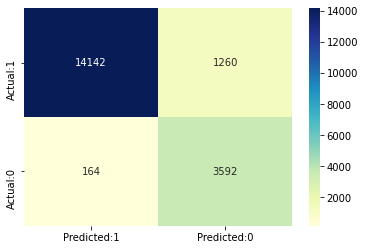

In [133]:
print("Training Accuracy :", lr.score(trainX, trainY))
print("Testing Accuracy :", lr.score(testX, testY))
con_mat = pd.DataFrame(
    confusion_matrix(lr.predict(testX), testY),
    columns=["Predicted:1", "Predicted:0"],
    index=["Actual:1", "Actual:0"],
)


print("\nCLASSIFICATION REPORT\n")
print(classification_report(lr.predict(testX), testY, target_names=["1", "0"]))

print("\nCONFUSION MATRIX")
plt.figure(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt="d", cmap="YlGnBu")

In [5]:
pipeline_ls = make_pipeline(
    CountVectorizer(
        tokenizer=RegexpTokenizer(r"[A-Za-z]+").tokenize, stop_words="english"
    ),
    LogisticRegression(max_iter=40000, verbose=8, random_state=128, n_jobs=-1),
)

In [6]:
trainX, testX, trainY, testY = train_test_split(dftrain.URL, dftrain.Label)

In [7]:
start_time = datetime.now()

pipeline_ls.fit(trainX, trainY)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 309.0min finished


Duration: 5:09:18.791853


In [8]:
pipeline_ls.score(testX, testY)

0.9125916723186045

In [9]:
pickle.dump(
    pipeline_ls, open("E:/Codes/Python/ML Phising Detector/phishing_detector.pkl", "wb")
)

In [10]:
loaded_model = pickle.load(
    open("E:/Codes/Python/ML Phising Detector/phishing_detector.pkl", "rb")
)

In [11]:
test = ["join-grupmabar-icapoerty.duckdns.org"]
probability = loaded_model.predict_proba(test)
result = loaded_model.predict(test)
print(probability, result)

[[0.00105086 0.99894914]] [1]


In [12]:
print(probability[0, 1])

0.9989491400501207
